In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data: pd.DataFrame = pd.read_csv("data.csv", index_col=0)
print(data.head())

          y        x1        x2        x3        x4        x5        x6  \
0  7.824944 -0.887890  0.949137  0.867185  0.905457 -0.564753  1.064772   
1 -0.284809  0.402109 -0.109812  0.353789 -0.368996  0.484929 -0.872589   
2 -5.551631 -0.114545 -1.603722  0.284455 -0.276847 -1.421414 -1.135600   
3  0.087262  0.832631  0.443724  0.472880  1.260798  0.589971 -0.150165   
4  0.169201  0.318175 -0.042458  0.014656  0.323378  0.425665  0.268726   

         x7        x8        x9       x10  
0  0.871957  0.073367 -0.468684 -1.518201  
1 -0.305881 -0.284581  0.547374 -0.755235  
2 -0.021529 -0.826239  0.647715 -2.370580  
3  1.148314  1.034029 -0.205375 -0.488831  
4  0.177851 -0.128694  0.110501  0.797469  


In [98]:
data_copy = data.copy()
X = data_copy['x4']
y = data_copy['y']
len(y)
X = torch.tensor(X).float()
y = torch.tensor(y).float()


In [99]:
print(X)

tensor([ 9.0546e-01, -3.6900e-01, -2.7685e-01,  1.2608e+00,  3.2338e-01,
        -1.9349e+00, -3.1194e-01, -1.2951e+00, -1.3465e+00,  8.9389e-01,
        -8.0203e-01,  1.2355e+00,  6.2386e-02, -7.0312e-02, -4.8115e-01,
        -1.4590e+00,  2.7325e-01, -8.9816e-02, -4.4337e-01, -1.0558e+00,
         2.8081e-01, -5.8181e-01, -1.4359e+00,  1.1273e+00, -1.1059e+00,
         1.0719e+00, -1.4179e-01,  2.7050e-01, -9.7087e-01, -3.9786e-01,
        -6.9223e-01, -9.0689e-02,  7.6818e-01,  5.6743e-01, -6.9296e-01,
         8.5189e-01,  1.0013e-01, -9.5198e-02, -1.9548e+00, -1.3466e-01,
         1.5498e+00, -1.9138e-01, -5.0023e-01,  3.7405e-01,  5.0537e-01,
         1.8012e-01,  1.1213e+00,  1.6108e-01,  1.7811e-01,  5.5126e-02,
         4.0747e-01,  8.0046e-01,  7.7718e-01,  1.6980e+00,  1.0271e+00,
         5.7082e-01,  7.4251e-01,  6.8271e-01, -2.0576e+00,  5.1968e-01,
         1.2237e+00, -1.6926e+00, -3.4368e-01, -3.2265e-01,  1.5586e-01,
        -2.2725e-01, -4.3527e-01, -6.8750e-01,  7.6

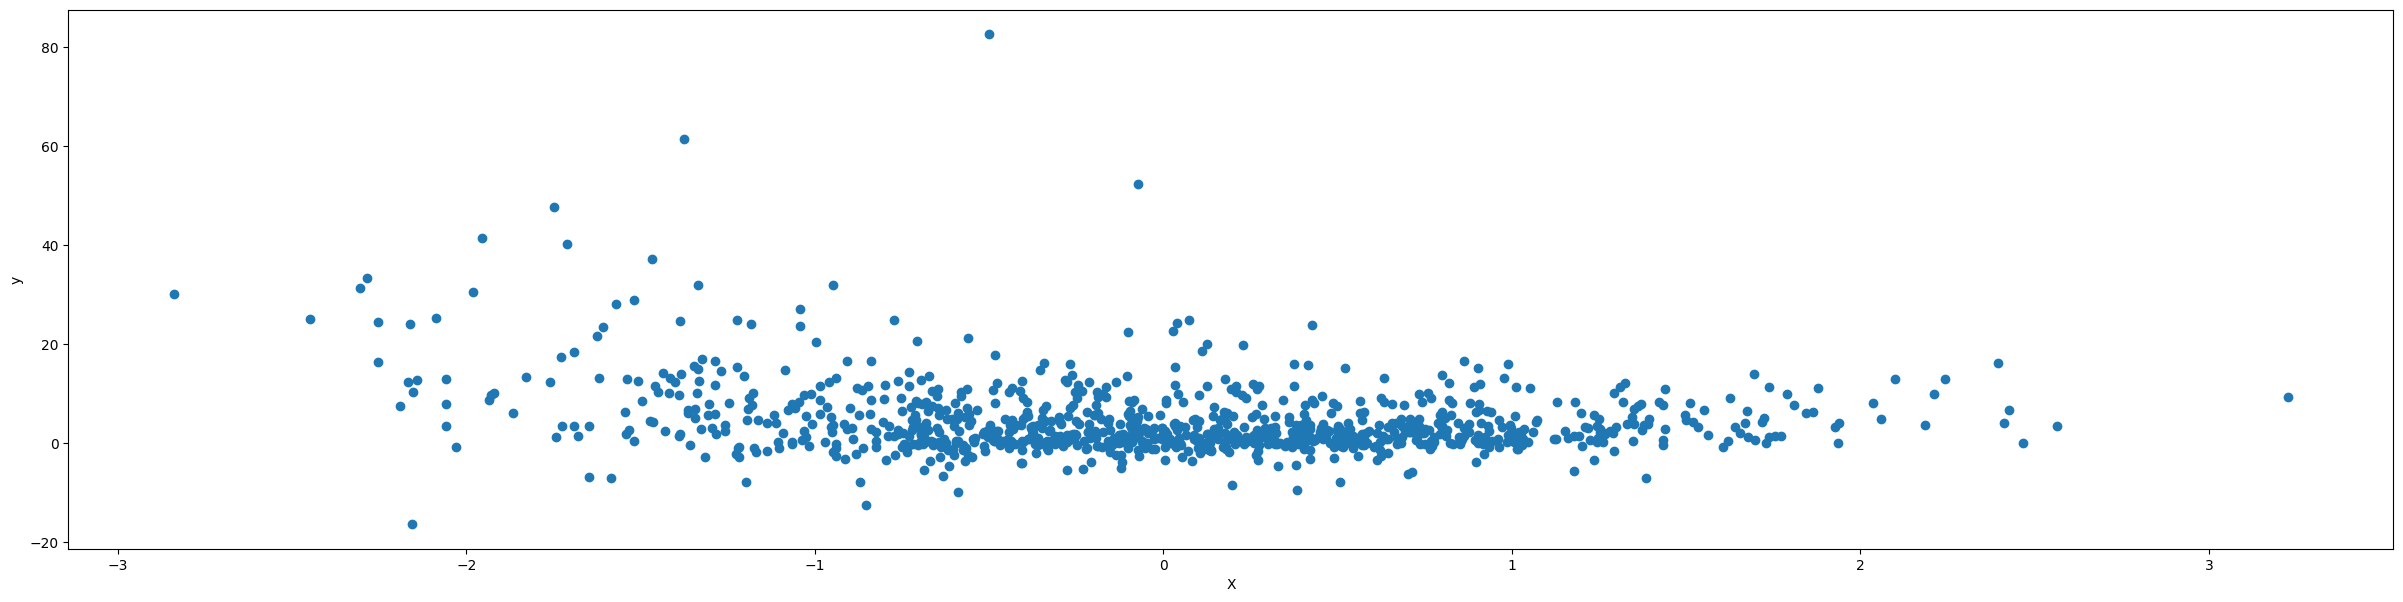

In [100]:
plt.figure(figsize = (30,7))
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [101]:
def plot_predictions(train_data: torch.Tensor,
                     train_labels: torch.Tensor,
                     test_data: torch.Tensor,
                     test_labels: torch.Tensor,
                     predictions: torch.Tensor = None):
    plt.figure(figsize=(5, 4))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size": 14});

In [102]:
splitter = int(0.8 * len(X))
X_train, X_test = X[:splitter], X[splitter:]
y_train, y_test = y[:splitter], y[splitter:]

print(f"Input Train: {X_train.shape}")
print(f"Input Test: {X_test.shape}")
print(f"Output Train: {y_train.shape}")
print(f"Output Test: {y_test.shape}")

y_test.dtype

Input Train: torch.Size([800])
Input Test: torch.Size([200])
Output Train: torch.Size([800])
Output Test: torch.Size([200])


torch.float32

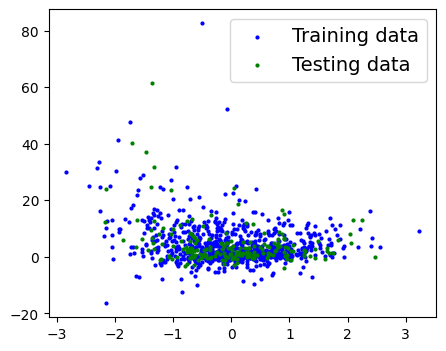

In [103]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test)

### Model Order Selection

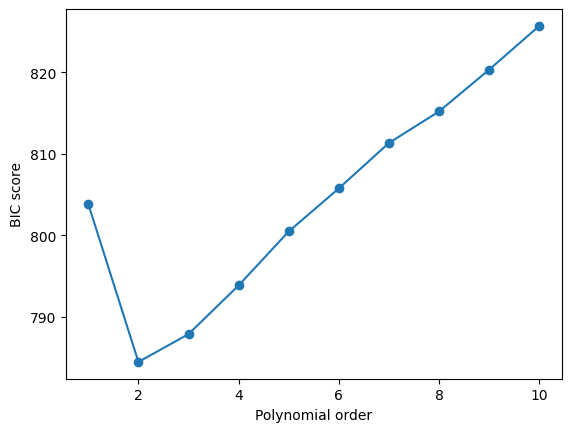

In [104]:
# Define the function to compute the BIC score
def compute_bic(n, k, mse):
    bic = n*np.log(mse) + k*np.log(n)
    return bic
    
# Define the hyperparameters
max_order = 10

# Train and evaluate models with different orders
bic_scores = []
for order in range(1, max_order+1):
    # Fit a linear regression model with polynomial features
    X_train_poly = np.column_stack([X_train**i for i in range(1, order+1)])
    model = LinearRegression().fit(X_train_poly, y_train)
    # Compute the mean squared error on the validation set
    X_test_poly = np.column_stack([X_test**i for i in range(1, order+1)])
    y_test_pred = model.predict(X_test_poly)
    mse = ((y_test - y_test_pred.astype(float))**2).mean()
    
    # Compute the BIC score
    bic = compute_bic(len(X_test), order+1, mse)
    bic_scores.append(bic)

# Plot the BIC scores for different orders
plt.plot(range(1, max_order+1), bic_scores, '-o')
plt.xlabel('Polynomial order')
plt.ylabel('BIC score')
plt.show()

In [105]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.W1 = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
        self.W2 = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
    def forward(self, x: torch.Tensor):
        y = self.W1 *x **2 + self.W2 * x + self.bias #  as the formula (y = W1 *x **2 + W2 * x + bias)
        return y

In [106]:
def divider():
    print("-----------------------------------")
    
model = PolynomialRegressionModel()
list(model.parameters())
divider()
print(model.state_dict())


-----------------------------------
OrderedDict([('W1', tensor([0.1447])), ('W2', tensor([0.0076])), ('bias', tensor([0.4993]))])


In [107]:
with torch.inference_mode():
    y_preds = model(X_test)

print(f"Values: {y_preds}")

Values: tensor([0.5167, 0.4998, 0.5165, 0.5118, 0.6399, 0.5772, 0.5686, 0.9014, 0.5655,
        0.5546, 1.1523, 0.6230, 0.5155, 0.5638, 0.5772, 0.5239, 0.5508, 0.6432,
        0.5198, 0.5550, 0.4993, 1.0050, 1.1140, 0.5033, 0.5393, 0.5644, 0.8351,
        0.5016, 0.5852, 0.5495, 0.5090, 0.5017, 0.5618, 0.9187, 0.4997, 0.5747,
        0.5115, 0.5602, 0.5109, 0.5041, 0.6044, 0.6557, 0.5827, 0.8323, 0.6413,
        0.5140, 0.7142, 0.5026, 0.5596, 0.4997, 0.5169, 0.5265, 0.5676, 0.5444,
        0.4993, 0.5149, 0.7668, 0.9098, 0.5019, 0.6497, 0.5017, 0.7330, 0.5068,
        0.9076, 0.6556, 0.5891, 0.5582, 0.6229, 0.7843, 1.2449, 0.6703, 0.5011,
        0.7390, 0.5288, 0.5516, 0.5027, 0.5653, 0.5641, 0.6301, 0.5002, 0.6245,
        0.5008, 0.6728, 0.8099, 0.6319, 0.5030, 0.5979, 0.5254, 0.5067, 0.5067,
        0.8660, 0.5807, 0.4994, 1.1286, 1.1592, 0.5689, 0.5446, 0.5583, 1.1621,
        0.5596, 0.5017, 0.6486, 0.5154, 0.5004, 0.5154, 0.6025, 0.5230, 0.8798,
        0.5301, 0.5507, 0.5285, 

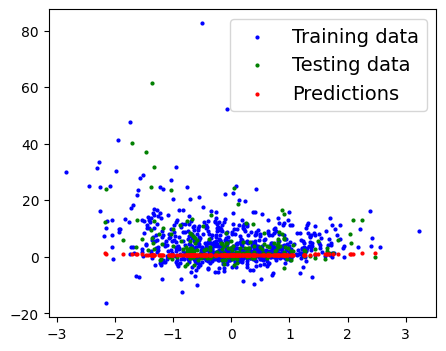

In [108]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [109]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), # model parameters to optimize
                              lr=0.001, # learning rate (how fast the model learns)
                            )

In [110]:
def train(
        model: nn.Module,
        train_data: torch.Tensor,
        train_labels: torch.Tensor,
        test_data: torch.Tensor,
        test_labels: torch.Tensor,
        loss_function: nn.Module,
        optimizer: torch.optim.Optimizer,
        epochs: int,
    ):
    epochs_count ,train_loss_arr, test_loss_arr = [], [], []
    for epoch in range(epochs+1):
        model.train()
        y_pred = model(train_data)
        loss = loss_function(y_pred, train_labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            y_pred = model(test_data)
            test_loss = loss_function(y_pred, test_labels)

        if epoch % 10 == 0:
            epochs_count.append(epoch)
            train_loss_arr.append(loss.detach().numpy())
            test_loss_arr.append(test_loss.detach().numpy())
            print(f"Epoch {epoch}: MAE Loss: {loss.item():0.2f} | Test Loss: {test_loss.item():0.2f}")
    return epochs_count, train_loss_arr, test_loss_arr

In [111]:
epochs_count, train_loss, test_loss = train(
                                        model, 
                                        train_data=X_train, 
                                        train_labels=y_train, 
                                        test_data=X_test, 
                                        test_labels=y_test, 
                                        loss_function=loss_function, 
                                        optimizer=optimizer, 
                                        epochs=3000
                                    )

Epoch 0: MAE Loss: 4.82 | Test Loss: 4.42
Epoch 10: MAE Loss: 4.81 | Test Loss: 4.41
Epoch 20: MAE Loss: 4.80 | Test Loss: 4.40
Epoch 30: MAE Loss: 4.79 | Test Loss: 4.39
Epoch 40: MAE Loss: 4.78 | Test Loss: 4.38
Epoch 50: MAE Loss: 4.78 | Test Loss: 4.37
Epoch 60: MAE Loss: 4.77 | Test Loss: 4.36
Epoch 70: MAE Loss: 4.76 | Test Loss: 4.36
Epoch 80: MAE Loss: 4.75 | Test Loss: 4.35
Epoch 90: MAE Loss: 4.74 | Test Loss: 4.34
Epoch 100: MAE Loss: 4.73 | Test Loss: 4.33
Epoch 110: MAE Loss: 4.72 | Test Loss: 4.32
Epoch 120: MAE Loss: 4.71 | Test Loss: 4.31
Epoch 130: MAE Loss: 4.71 | Test Loss: 4.30
Epoch 140: MAE Loss: 4.70 | Test Loss: 4.29
Epoch 150: MAE Loss: 4.69 | Test Loss: 4.29
Epoch 160: MAE Loss: 4.68 | Test Loss: 4.28
Epoch 170: MAE Loss: 4.67 | Test Loss: 4.27
Epoch 180: MAE Loss: 4.67 | Test Loss: 4.26
Epoch 190: MAE Loss: 4.66 | Test Loss: 4.25
Epoch 200: MAE Loss: 4.65 | Test Loss: 4.24
Epoch 210: MAE Loss: 4.64 | Test Loss: 4.24
Epoch 220: MAE Loss: 4.64 | Test Loss: 4.23

In [112]:
def plot_stats(
        epochs: list,
        train_loss: list,
        test_loss: list,
    ):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, test_loss, label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

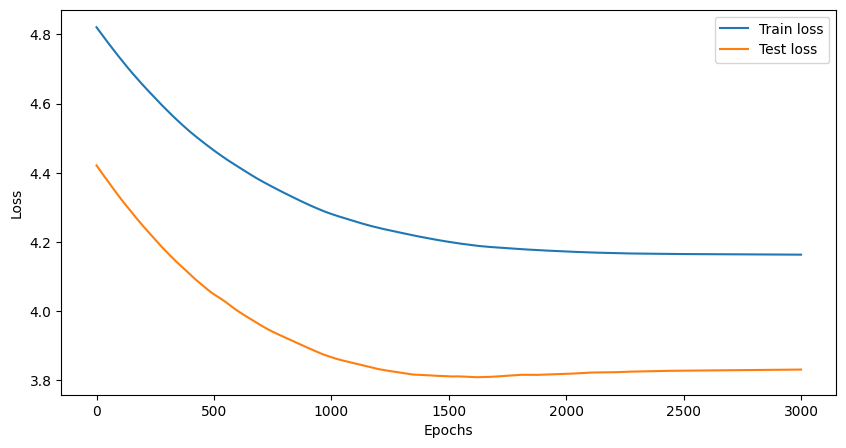

In [113]:
plot_stats(epochs_count, train_loss, test_loss)

In [114]:
def predict(model, X):
    with torch.inference_mode():
        y_pred = model(X)
        return y_pred

In [115]:
y_preds = predict(model, X_test)

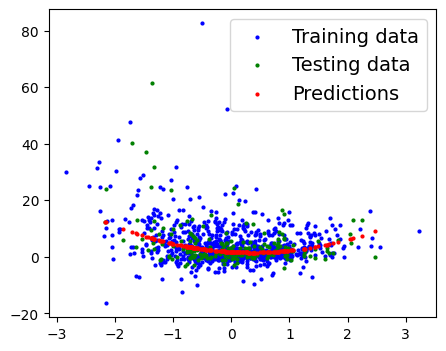

In [116]:
plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=y_preds,
)

In [117]:
print(f"Model Parameters: {model.state_dict()}")

Model Parameters: OrderedDict([('W1', tensor([1.6803])), ('W2', tensor([-1.2119])), ('bias', tensor([1.7199]))])


In [67]:
# Save model
from pathlib import Path

# Create a folder to save our models
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

# Save the model
model_name = 'model.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

Saving model to: models/model.pth
